In [1]:
from astropy.io import fits as pyfits
import matplotlib.pyplot as pl
import glob
import os
from tqdm import tqdm
from scipy.ndimage.measurements import label
import tensorflow as tf
from scipy.signal import savgol_filter
import numpy as np
%matplotlib inline

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [23]:
def SavGol(y, win=49):
    if len(y) >= win:
        return y - savgol_filter(y, win, 2) + np.nanmedian(y)
    else:
        return y

    
def Interpolate(time, mask, y):
    yy = np.array(y)
    t_ = np.delete(time, mask)
    y_ = np.delete(y, mask, axis=0)
    if len(yy.shape) == 1:
        yy[mask] = np.interp(time[mask], t_, y_)
    elif len(yy.shape) == 2:
        for n in range(yy.shape[1]):
            yy[mask, n] = np.interp(time[mask], t_, y_[:, n])
    else:
        raise Exception("Array ``y`` must be either 1- or 2-d.")
    return yy


def InterpolateOverOutliers(target_lc, tol=3, win=49):
    f = SavGol(target_lc, win)
    med = np.nanmedian(target_lc)
    MAD = 1.4826 * np.nanmedian(np.abs(f - med))
    outliers = np.where((f > med + tol * MAD) | (f < med - tol * MAD))[0]
    target_lc = Interpolate(time, outliers, target_lc)
    return target_lc


def getFlux(plot=True):
    """Return a (random) stitching of the postage stamps for C9."""
    np.random.seed(1234)
    ntime = 1287
    nrows = 250
    ncols = 250
    ntries = 500
    satlim = 150000
    flux = np.zeros((ntime, nrows, ncols)) * np.nan
    files = glob.glob('data/c9/*/*/*.fits.gz')
    nantime = None
    for file in tqdm(files):
        with pyfits.open(file) as f:
            time = f[1].data['TIME']
            ftmp = f[1].data['FLUX']
            
            # Delete NaN timestamps
            if nantime is None:
                nantime = np.where(np.isnan(time))
            else:
                assert np.allclose(nantime, np.where(np.isnan(time))), "Mismatch in NaN inds."
            time = np.delete(time, nantime)
            ftmp = np.delete(ftmp, nantime, axis=0)
            
            # Reject saturated stars
            if np.nanmax(ftmp) > satlim:
                continue
            for i in range(ntries):
                row = np.random.randint(0, nrows - ftmp.shape[1])
                col = np.random.randint(0, ncols - ftmp.shape[2])
                if np.all(np.isnan(flux[0, row:row + ftmp.shape[1], col:col + ftmp.shape[2]])):
                    flux[:, row:row + ftmp.shape[1], col:col + ftmp.shape[2]] = ftmp
                    break
            if i == ntries - 1:
                raise Exception("Unable to place image.")
    if plot:
        fig = pl.figure(figsize=(14, 14))
        pl.imshow(flux[0], vmax=1e4);
    return time, flux

100%|██████████| 187/187 [00:13<00:00, 13.95it/s]


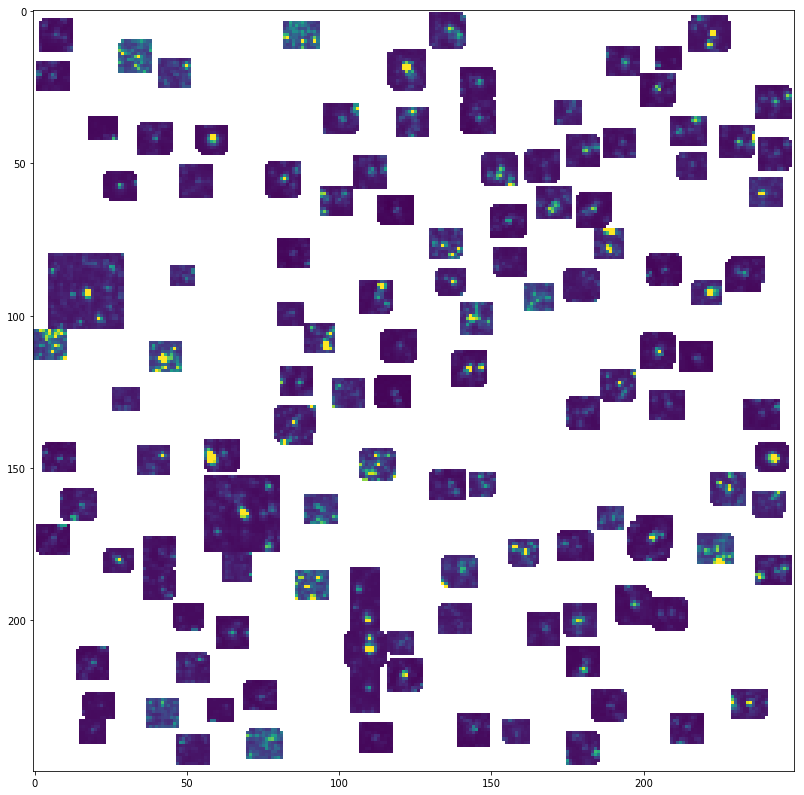

In [24]:
# Get the flux
time, flux = getFlux(True)

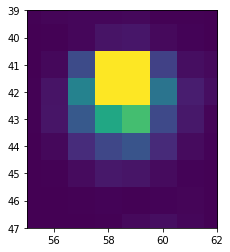

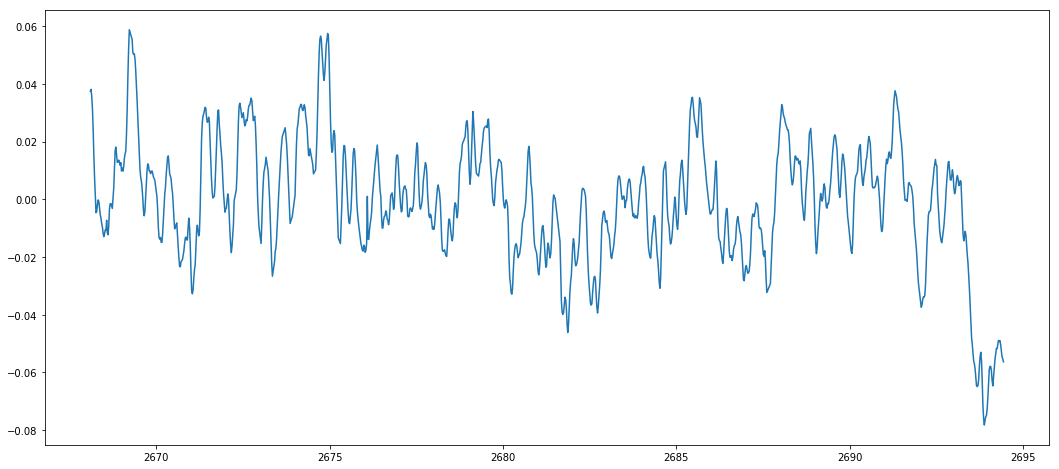

In [25]:
# This is our target
pl.imshow(flux[0], vmax=1e4)
c0 = 55
c1 = 62
r0 = 39
r1 = 47
pl.xlim(c0, c1);
pl.ylim(r1, r0);

# This is its raw light curve
target = flux[:, r0:r1, c0:c1]
target_lc = np.nansum(target, axis=(1, 2))
target_lc = target_lc / np.nanmedian(target_lc) - 1
target_lc = InterpolateOverOutliers(target_lc, 2)
fig = pl.figure(figsize=(18, 8))
pl.plot(time, target_lc);

In [26]:
# Remove it from the image so we don't use it
# as a regressor.
flux[:, r0:r1, c0:c1] = np.nan

/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


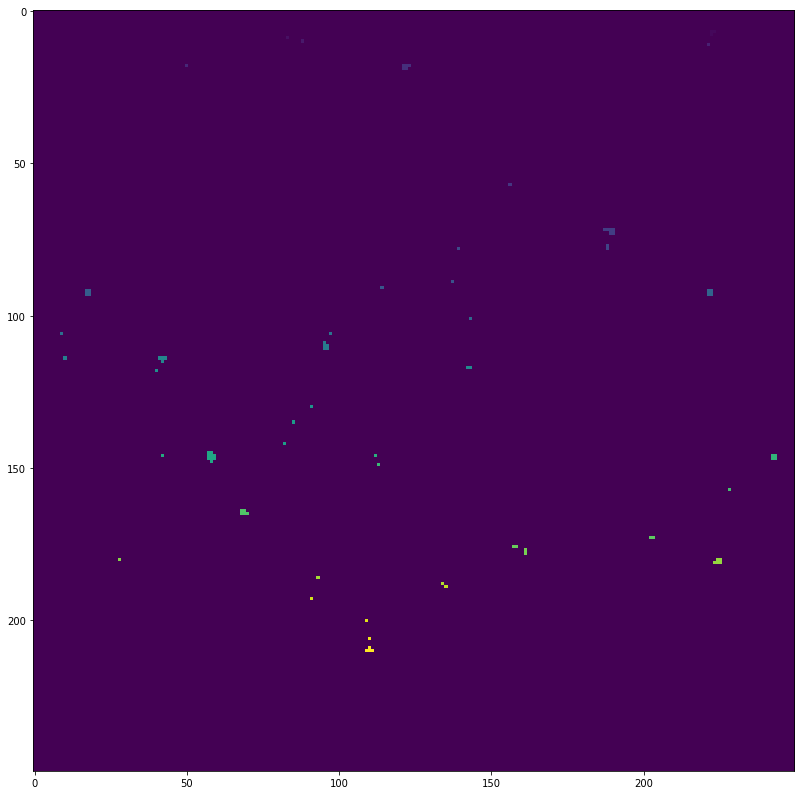

In [27]:
# Label sources
img = np.nanmedian(flux, axis=0)
mu = np.nanmedian(img)
sigma = np.sqrt(np.nanmedian((img-mu)**2))
m = (img - mu) > 40*sigma
m &= np.isfinite(img)
labels, nstar = label(m)
fig = pl.figure(figsize=(14, 14))
pl.imshow(labels);

In [28]:
# Get our regressors
lcs = np.empty((nstar-1, len(flux)), dtype=np.float32)
for star in range(nstar-1):
    lcs[star] = np.sum(flux[:, labels == star+1], axis=1)
lcs = lcs / np.median(lcs, axis=-1)[:, None] - 1
for i, lc in enumerate(lcs):
    lcs[i] = InterpolateOverOutliers(lcs[i], 2) 

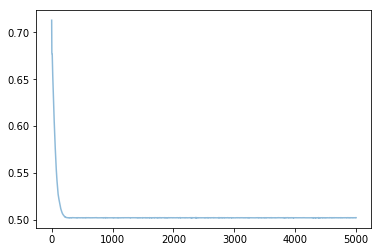

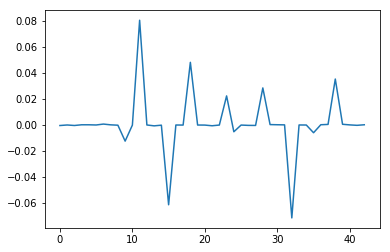

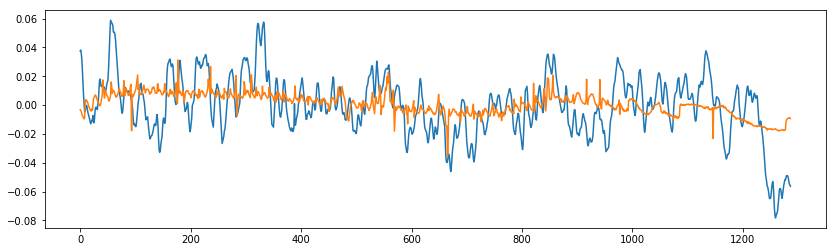

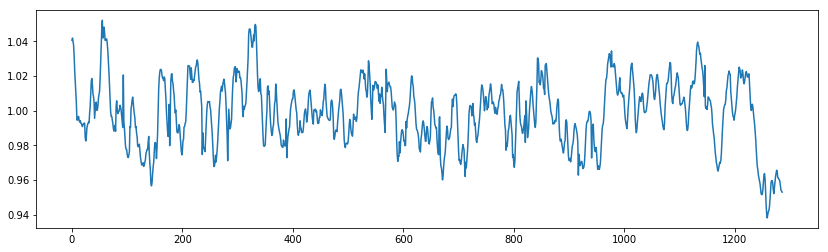

In [29]:
# Tensorflow magic
T = tf.float32
np.random.seed(42)

session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

y = tf.constant(target_lc, dtype=T)
X = tf.constant(lcs.T, dtype=T)

A0 = X.eval()
w0 = np.linalg.solve(np.dot(A0.T, A0), np.dot(A0.T, y.eval()))

lam = tf.constant(1e-1, dtype=T)
w = tf.Variable(w0, dtype=T)

mod = tf.squeeze(tf.matmul(X, w[:, None]))
loss0 = tf.reduce_sum((y - mod)**2)
loss1 = lam * tf.reduce_sum(tf.abs(w))
loss = loss0 + loss1

opt = tf.train.AdamOptimizer(1e-3).minimize(loss)

XTX = tf.matmul(X, X, transpose_a=True)
XTy = tf.matmul(X, y[:, None], transpose_a=True)
bk = tf.reduce_sum(tf.abs(w))
wk = tf.squeeze(tf.linalg.solve(XTX + lam/bk * tf.eye(lcs.shape[0]), XTy))
opt_ze = tf.assign(w, wk)

init = tf.global_variables_initializer()
session.run(init)

# Fancy losses
losses_fancy = np.empty(5000)
for i in range(len(losses_fancy)):
    if i < 10:
        session.run(opt_ze)
    else:
        session.run(opt)
    losses_fancy[i] = loss.eval()
    
# Show losses
pl.plot(losses_fancy, alpha=0.5)
#pl.yscale("log")

# Show weights
fig = pl.figure()
pl.plot(w.eval());

# Show model and data
fig = pl.figure(figsize=(14, 4))
pl.plot(y.eval());
pl.plot(mod.eval());

# Show de-trended
fig = pl.figure(figsize=(14, 4))
pl.plot(1 + y.eval() - mod.eval());